# 8 Easy Steps To Switch From Pandas to Lightning Fast Polars And Never Return
## A cheat sheet of the most common Pandas operations translated into Polars
![](images/midjourney.png)

### Time for goodbyes!

Pandas can do anything. Virtually anything. But (and this is a I-wish-a-million-times-it-was-any-other-way _but_) it lacks speed. Pandas just can't keep up with the pace at which the size and complexity of today's datasets are growing.

Pandas author, Wes McKinney, states that when he wrote Pandas, he had this rule of thumb in mind for his library:

> Have 5 to 10 times as much RAM as the size of your dataset.

Maybe you could've snoozed past this rule when the Iris dataset was first introduced, but today, it is totally different. You simply can't load a 100GB dataset (already common in modern times) when your RAM is _resolutely_ stuck at 64GB. 

Sure, there are great alternatives like Dask. But Dask doesn't implement new functionality. It spreads existing Pandas syntax over multiple processes (threads) and ignores the underlying performance and memory issues. It treats Pandas as __black box__. Forgive me for saying this, but it is almost like putting a lipstick on a pig.

Polars, the focus of our article, was written in Rust from the ground-up to fix all the shortcomings of Pandas. We've already seen in [my last article](https://towardsdatascience.com/measuring-the-speed-of-new-pandas-2-0-against-polars-and-datatable-still-not-good-enough-e44dc78f6585) how it is already faster than the upcoming Pandas 2.0 with PyArrow backend. 

While that article focused on speed advantages, this one focuses more on the syntax and functionality and shows you how to switch from Pandas to Polars in seven easy steps and maybe, never switch back.

### 0. Reading/writing data

Even though it is painfully slow, CSV is still one of the most popular file formats to store data. So, let's start with the `read_csv` function of Polars.

Apart from the obvious speed benefits, it only differs from its Pandas namesake in terms of the number of parameters (Pandas `read_csv` has 49. Yep, I counted) and syntax.

![](images/csv_io.png)

The confusing parameter names shouldn't be a problem as most modern IDEs have tab-completion or pop-up documentation features (__Shift + Tab__ on JupyterLab, thank you 🙏). 

If you were unaware, the `dtype` parameter prevents Pandas to set automatic datatypes and allows the user set custom ones like `string` type for `cut` or `datetime` for date-type columns.

You can use the same behavior in Polars with `dtypes` (mind the 's') though it doesn't allow the types to be set via strings. You have to provide either Python built-in types or through Polars like `pl.Boolean`, `pl.Categorical`, `pl.DateTime`, `pl.Int64` or `pl.Null` for missing values. You can see the full list by calling `dir(pl)`.

Reading and writing Parquet files, which are much faster and more memory-efficient that CSVs, are also supported in Polars through `read_parquet` and `write_parquet` functions.

![](images/parquet_io.png)

### 1. Creating Series and DataFrames

You don't always read data from files. Like in Pandas, you can create DataFrames and Series from scratch and the syntaxes are almost identical:

![](images/create_series.png)

![](images/create_df.png)

There are also many name and behavior-(almost)-identical methods of Polars DataFrames to Pandas. Say hello to:

- [`apply`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.apply.html#polars.DataFrame.apply) - Apply custom user-defined functions on each row of the DataFrame
- [`corr`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.corr.html#polars.DataFrame.corr) - correlation matrix
- [`describe`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.describe.html#polars.DataFrame.describe) - Summary statistics, 5-number summary
- [`drop`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.drop.html#polars.DataFrame.drop) - Remove columns from a DataFrame
- [`explode`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.explode.html#polars.DataFrame.explode) - Unpacking the given column to long format (when cells contain multiple values like `[1, 2, 3]`)
- [`head`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.head.html#polars.DataFrame.head), [`tail`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.tail.html#polars.DataFrame.tail) and [`sample(n)`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.sample.html#polars.DataFrame.sample) - get different views of the DataFrame (top, bottom, random)
- [`iter_rows`](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.iter_rows.html#polars.DataFrame.iter_rows) - returns an iterator of DataFrame rows of Python-native values
- `max`, `mean`, `median`, `sum`, `std` and the usual gang of common math and statistical functions.

and so on. Check out [this page](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/index.html) of the docs for the full list of DataFrame methods in Polars.

### 2. Understanding expressions in Polars

At the core of Polars is its __query engine__, which runs user-defined __expressions__. The query engine and expressions are two critical components for Polars' blazing fast and as Polars user guide puts it, "embarrassingly parallel" performance. 

You may be shocked at how closely Polars expressions resemble SQL while still keeping firm ties to the familiar Pandas syntax.

Like SQL queries, you can write expressions for:

- Creating new columns from existing ones
- Getting views of the data after some transformation
- Summary statistics
- Processing and cleaning data
- Groupby statements

and so on. 

```python
df.filter(pl.col('column') == 'some_value')
```

In the above query, the expression is `pl.col('column)' == 'some_value'`, which as you guess, _filters_ the DataFrame for rows where `column` is equal to `some_value`.

When you run the expression on its own, you won't get a boolean Series like you would in Pandas:

In [41]:
type(pl.col("column") == "some_value")

polars.expr.expr.Expr

That's because expressions are only evaluated under _contexts_. There are three broad contexts in Polars: 

1. Selecting data - in the `select` context, expressions are applied over columns and must produce columns of the same length in the result. This behavior must be familiar from SQL. The `filter` function is also tied into this context.
2. Grouping data - in the `groupby` context, expressions work on groups and the results may have any length as a group can have many members.
3. Adding new columns - in this context, expressions are used to create new columns from scratch or off of existing ones.

Let's see each context in detail.

### 3. Selecting data

The Pandas' brackets notation gives way to expressions in Polars for selecting columns. 

To select a single column, you can use their literal names inside `select` or use the recommended `pl.col` function to reference columns. 

To select multiple, you can list the column names with commas inside `pl.col` or as a list of `pl.col` references inside `select`. We will see the differences between these syntaxes in a bit.

![](images/select.png)

Polars includes certain functionality not fully available in Pandas for selecting data. For example, you can exclude columns in your selection with `exclude`:

```python
df.select(pl.exclude("price")).head()
```

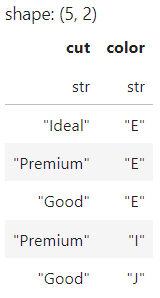

Or use regular expressions between `^` and `$` characters. Below, we are choosing all columns that start with the letter _c_:

```python
df.select(pl.col("^c.+$")).head()
```

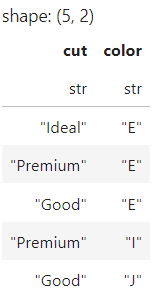

You can also subset the DataFrame based on data type, which might remind you of `select_dtypes` of Pandas (on the left):

![](images/include_number.png)

To select all numeric columns, we are using both `Int64` and `Float64` types inside `pl.col`.

### 4. Filtering data

You can use the `filter` function to subset DataFrames with boolean indexing. For example, when you use `is_between` function on a column, it creates an expression to filter numeric columns within a range. 

![](images/is_between.png)

You can combine multiple _conditional expressions_ with the familiar boolean operators `&` (AND), `|` (OR). In the example below, we are choosing rows where the `color` column is either 'E' or 'J' AND the `price` of diamonds are below 500:

![](images/isin.png)

Also notice how we are using `is_in` in Polars on the right.

### 5. Creating new columns

You can create new columns under the `with_columns` context. In the example below, `new_col` is defined using `pl.col('price') ** 2` and aliased to give the new column a name, just like `as` keyword in SQL.

![](images/new_col.png)

In the second example, we are combining two columns (even though it doesn't make sense), which demonstrates how integer and string columns can be combined with Polars. You can use any native Python or third-party function and operator on columns referenced with `pl.col`. 

If you want the new column be inserted into the DataFrame, you have to override the original `df` variable.

> While we are at it, string columns in Polars have the familiar `.str` interface for special text manipulation functions like `contains` or `lengths`. See the full list [here](https://pola-rs.github.io/polars/py-polars/html/reference/series/string.html). There are also [`.cat`](https://pola-rs.github.io/polars/py-polars/html/reference/series/categories.html), [`.dt`](https://pola-rs.github.io/polars/py-polars/html/reference/series/temporal.html) and [`.arr`](https://pola-rs.github.io/polars/py-polars/html/reference/series/list.html) interfaces for specialized categorical, temporal and array functions.


### 6. Groupby

I don't think we can leave without mentioning `Groupby` operations:

![](images/groupby.png)

When using the `groupby` function in Polars, be sure to include `maintain_order=True` so that groups are not displayed randomly. Also, unlike Pandas, `groupby(col_name)` expression only works on the given column. To group all columns based on `col_name`, you have to use an aggregation context. Here is its syntax:

```python
df.groupby(
    "cut", maintain_order=True
).agg(pl.col("*").count())
```

After the `groupby` context, you chain the aggregation context and specify which columns the context affects. And, chain any function on the result like `count`. 

Here is another example that groups by the diamond cut quality and returns the average numeric value for each group:

![](images/agg.png)

To learn more advanced groupby expressions in Polars, read [here](https://pola-rs.github.io/polars-book/user-guide/dsl/groupby.html).

### 7. The lazy API in Polars

One of the best features of Polars is its lazy API. In it, queries are run line-by-line but processed end-to-end by the query engine. 

This is where query optimization and the _embarrassingly parallel_ magic happens. You can turn any expression written in __eager mode__ into lazy mode with only two keywords:

In [51]:
import polars as pl

df = pl.read_csv("data/diamonds.csv")

query = df.lazy().filter(
    pl.col("cut") == "Ideal"
)

type(query)

polars.lazyframe.frame.LazyFrame

When you add the `lazy()` function before an expression is chained, the DataFrame becomes a `LazyFrame`. At this point, the query isn't executed and you can chain more expressions. Once ready, you call `collect()` to get the result:

```python
query.collect().head()
```

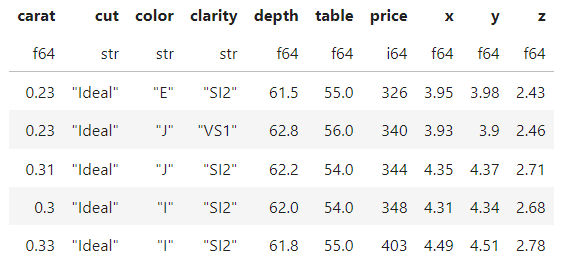

While it is already fast in eager mode, the lazy mode adds exxxtra (yes, triple x) fuel to the query engine. 

If you want to make the lazy API your default rather than eager mode, you can use `scan_*` functions when reading data instead of `read_*`:

```python
df = pl.scan_csv("data/diamonds.csv")

q1 = df.filter(
    pl.col("cut") == "Ideal"
)

q1.collect().head()
```

This way, you avoid writing the `lazy()` function every time. 

If you are dealing with datasets that are bigger than your RAM, you can use streaming so that Polars processes your data in batches. This feature is enabled in the lazy API by setting `streaming=True` inside `collect`. Find out more about this awesome feature from [this page](https://pola-rs.github.io/polars-book/user-guide/lazy-api/streaming.html).

### Conclusion

Polars might be new (I mean, it is fresh out of its crib) but it is already very popular. In the ope-source standards, it is a rock-star. Just look at its competitors:

1. Pandas, released 2011, 37.5k GitHub stars.
2. Apache Spark, released 2014, 26.8k stars.
3. Vaex, released 2017, 7.9k GitHub stars.
4. Dask, released 2015, 10.9k stars.
5. Apache Arrow, released 2016, 11.4k stars.

In comparison, Polars was released in 2020 and already amassed 15.9k stars, already half of its long-standing top competitors. 

This should give you a rough picture of where the wind is blowing. Things might change when Pandas 2.0 is released but I think Polars is already giving Pandas a run for its money.